In [3]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(1, '/Users/andrew/Documents/python/pygplates_rev28_python37_MacOS64')
import pygplates
import xarray as xr
import os
from os import walk
import pickle

import rockhound as rh
from rockhound.slab2 import ZONES
import pygmt
import slab_tracker_utils as slab
import splits_and_merges as snm
import slab_cross_section_utils as sxs
import slab_workflow

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
import cartopy.crs as ccrs
import serpentinite_spreading_grids

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

#for some reason we get repetitive deprecation warnings, so this mutes them
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning) 




In [4]:
#set directories
platedir = '/Users/andrew/Documents/GitHub/EarthBytePlateMotionModel-ARCHIVE/Muller++_2015_AREPS_CORRECTED/'
savedir = '/Users/andrew/Documents/Data/Merdith_sub_zones/'
datadir = '/Users/andrew/Documents/Data/Merdith_sub_zones/'

#model files
rotfile = '%sGlobal_EarthByte_230-0Ma_GK07_AREPS.rot' % platedir
COBs = '%sAgeGridInput/Global_EarthByte_230-0Ma_GK07_AREPS_COB_Terranes.gpml' % platedir
coastlines = '%sGlobal_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpml' % platedir
isochrons = '%sAgeGridInput/Global_EarthByte_230-0Ma_GK07_AREPS_Isochrons.gpml' % platedir
input_topology_filename = ['%sGlobal_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries_ASM.gpml' % platedir,
                           '%sGlobal_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml' % platedir]

rotation_model = pygplates.RotationModel(rotfile)

#topologies for our subduction points
time = 0 

resolved_topologies = []
shared_boundary_sections = []

pygplates.resolve_topologies(input_topology_filename, rotation_model,
                             resolved_topologies, int(time), shared_boundary_sections)
#deterministic output
shared_boundary_sections = sorted(shared_boundary_sections, 
                                  key=lambda section : section.get_feature().get_feature_id().get_string())
#some densities
perid_density_g_cm3 = 3.3 #g/cm3
perid_density_g_km3 = perid_density_g_cm3 * 100000**3
perid_density_kg_km3 = perid_density_g_km3 * 1e-3

Make cross-sections along subudction zones to sample results

In [5]:
cross_section_start_points, sub_length, segments, polarity = slab_workflow.get_sub_parameters(shared_boundary_sections)

Unable to find the overriding plate of the subducting shared sub-segment "So Melanesian-MG-5-20-07"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "So Melanesian-MG-5-20-07"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding and subducting plates of the subducting shared sub-segment "" at 0Ma
    there are not exactly 2 topologies sharing the sub-segment.
224
Unable to find the overriding and subducting plates of the subducting shared sub-segment "" at 0Ma
    there are not exactly 2 topologies sharing the sub-segment.
911


In [6]:
forward_distance = 3
back_distance = 1

cross_section_start_points, cross_section_end_points = slab_workflow.make_cross_section(forward_distance, back_distance,
                                                   cross_section_start_points, segments, polarity)

#have to convert our longitude points to 0–360 to accommodate rockhound (i think, super annoying)
for ind,i in enumerate(cross_section_end_points[:,1]):
    if i < 0:
        cross_section_end_points[ind][1] = i+360
for ind,i in enumerate(cross_section_start_points[:,1]):
    if i < 0:
        cross_section_start_points[ind][1] = i+360        

In [7]:
#load our other data needed to populate the cross section
#open slab2 geometry (made in in Slab2_geometry_Py3 notebook)
ds_in = xr.open_dataset('%sSlab2point0/sub_zones_Slab2_no_halmahera.nc' % datadir)
#organise our dataarray so its stacked
ds_stacked = ds_in.stack(x=['latitude','longitude'])


#peridotite grid
grid_filename = ['/Users/andrew/Documents/Data/Chapman_arc_flare_up_DATA/thickness_grids/peridotite_thickness_post_serpentinisation','_Ma.nc',
                 '/Users/andrew/Documents/Data/plate_model_grids/AREPS_CORRECTED-agegrid/Muller_etal_2016_AREPS_v1.17_AgeGrid-','.nc',
                 '/Users/andrew/Documents/Data/plate_model_grids/AREPS_CORRECTED-spreadrate/Mask/rategrid_final_mask_','.nc']


output_data = slab_workflow.get_subducted_slabs(5., 0.0, 1.0, 
                                                grid_filename, 
                                                ds_stacked)

#close datasets as we no longer need them
del ds_in
del ds_stacked



plates that persist between 6.00 Ma and 5.00 Ma are: 
 {645, 646, 901, 904, 903, 909, 653, 911, 659, 406, 664, 669, 801, 802, 676, 677, 678, 301, 686, 815, 818, 821, 566, 824, 701, 829, 709, 328, 969, 970, 201, 334, 849, 337, 340, 607, 224, 608, 101, 501, 503, 511}

plates that appeared between 6.00 Ma and 5.00 Ma are: 
 {564, 699}

plates that disappeared between 6.00 Ma and 5.00 Ma are: 
 {819, 972}

Working on appearing plates
Centroid for plate 564 mapped to plate 678 at delta time
Centroid for plate 699 mapped to plate 659 at delta time

Working on disappearing plates
Centroid for plate 819 mapped to plate 818 at delta time
Centroid for plate 972 mapped to plate 911 at delta time
[(819, 818), (972, 911)]
here (819, 972)
plates that persist between 5.00 Ma and 4.00 Ma are: 
 {645, 646, 901, 904, 903, 909, 653, 911, 659, 406, 664, 669, 801, 802, 676, 677, 678, 301, 686, 815, 818, 821, 566, 824, 699, 701, 829, 709, 328, 201, 970, 969, 334, 337, 849, 340, 607, 224, 608, 101, 501, 503,

Unable to find the overriding plate of the subducting shared sub-segment "Woodlark MOR"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".


Using 5.00 to 4.00 Ma stage pole for plate 564
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 5.00 to 4.00 Ma stage pole for plate 564
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
time 4.00 Ma
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904


Unable to find the overriding plate of the subducting shared sub-segment "Woodlark MOR"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".


Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
Using 4.00 to 3.00 Ma stage pole for plate 904
time 3.00 Ma


Unable to find the overriding plate of the subducting shared sub-segment "" at 3.0Ma
    both sharing topologies are on subducting side of subducting line.
Unable to find the overriding plate of the subducting shared sub-segment "Woodlark MOR"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".


time 2.00 Ma


Unable to find the overriding plate of the subducting shared sub-segment "" at 2.0Ma
    both sharing topologies are on subducting side of subducting line.
Unable to find the overriding plate of the subducting shared sub-segment "Woodlark MOR"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".


time 1.00 Ma


Unable to find the overriding plate of the subducting shared sub-segment "" at 1.0Ma
    both sharing topologies are on subducting side of subducting line.
Unable to find the overriding plate of the subducting shared sub-segment "So Melanesian-MG-5-20-07"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "So Melanesian-MG-5-20-07"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding and subducting plates of the subducting shared sub-segment "NAM subduction COB" at 1.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
901
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding and subducting plates of the subducting shared s

time 0.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "" at 0.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
224
Unable to find the overriding and subducting plates of the subducting shared sub-segment "" at 0.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
911
Unable to find the overriding plate of the subducting shared sub-segment "So Melanesian-MG-5-20-07"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "So Melanesian-MG-5-20-07"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".


In [8]:
#get cross section points
steps = 200
cross_section_points, cross_section_lines, intersecting_lines = slab_workflow.populate_cross_section(output_data,
                                                                                       cross_section_end_points, 
                                                                                       cross_section_start_points,
                                                                                       steps)

#save as pickle
with open('%scross_section_lines.pickle' % savedir, 'wb') as f:
    pickle.dump([i.to_lat_lon_array() for i in cross_section_lines], f)

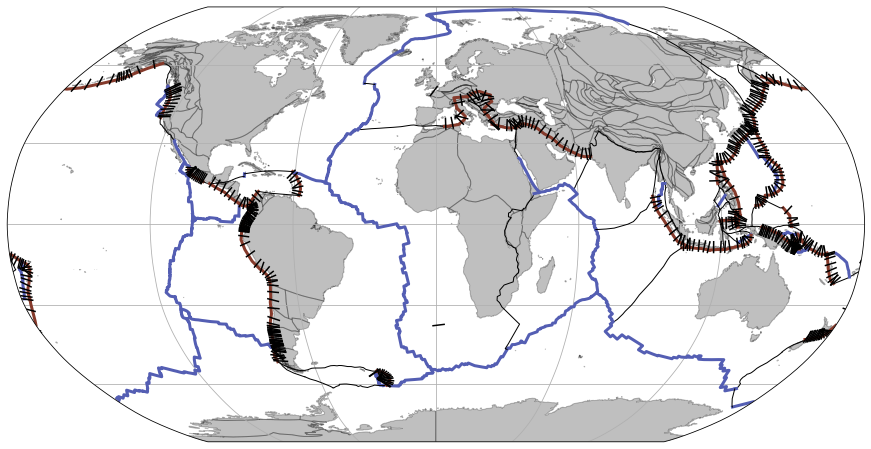

In [9]:
###plot cross sections
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8),
                     subplot_kw={'projection': ccrs.Robinson()})
date_line_wrapper = pygplates.DateLineWrapper(0)
data_crs = ccrs.Geodetic()
poly_data_crs = ccrs.PlateCarree()
for i in cross_section_lines:
    start_point = i.to_lat_lon_array()[0]
    end_point = i.to_lat_lon_array()[-1]
    #print(i.to_lat_lon_array()[0], i.to_lat_lon_array()[-1])
    ax.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]],
            c='k',
            zorder=3,
            transform=data_crs)

reconstructed_polygons = []

pygplates.reconstruct(coastlines,rotation_model, reconstructed_polygons, int(time))
for polygon in reconstructed_polygons:
    poly_geom = pygplates.PolygonOnSphere(polygon.get_reconstructed_geometry())
    wrapped_polys = date_line_wrapper.wrap(poly_geom, 1)
    for wrapped_poly in wrapped_polys:
        wrapped_poly_lat = []
        wrapped_poly_lon = []
        for wrapped_poly_point in wrapped_poly.get_exterior_points():
            wrapped_poly_lat.append(wrapped_poly_point.get_latitude())
            wrapped_poly_lon.append(wrapped_poly_point.get_longitude())

        ax.fill(wrapped_poly_lon, wrapped_poly_lat, color='k', alpha=0.25,
                linewidth=1 ,zorder=1, transform=poly_data_crs)

for shared_boundary_section in shared_boundary_sections:
    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                mor_wrapped_point_lat = []
                mor_wrapped_point_lon = []
                for wrapped_point in wrapped_polyline.get_points():
                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#545eb3',
                        linewidth=3, alpha=1, zorder=2, transform=data_crs)

    elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                mor_wrapped_point_lat = []
                mor_wrapped_point_lon = []
                for wrapped_point in wrapped_polyline.get_points():
                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#853a2b',
                        linewidth=3, alpha=1, zorder=2, transform=data_crs)                
    else:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                mor_wrapped_point_lat = []
                mor_wrapped_point_lon = []
                for wrapped_point in wrapped_polyline.get_points():
                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='k',
                        linewidth=1, alpha=1, zorder=2, transform=data_crs)

gl = ax.gridlines()
gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
#ax.scatter(134, 31, c='green', s=100,transform=poly_data_crs, zorder=4)
#ax.plot(test_lon, test_lat, c='green',transform=poly_data_crs, zorder=4)
#extent=[longitude_top_left,longitude_top_right,latitude_bottom_left,latitude_top_left]
#ax.set_extent([115, 130, 0, 10], crs=ccrs.PlateCarree())
#ax.scatter(test_lon[0], test_lat[0], c='blue', transform=poly_data_crs, zorder=5)
#ax.scatter(test_lon[-1], test_lat[-1], c='red', transform=poly_data_crs, zorder=5)
ax.set_global()
#fig.savefig('/Users/andrew/Documents/Manuscripts/Merdith_2021_serpentinite_sub_zones/cross_sections.pdf')

Get slab2.0 data

In [10]:
####
#all sections
# Fetch all Slab2 subduction zones and add them inside a list
subduction_zones = []
for zone in ZONES:
    if zone == 'halmahera':
        continue
    subduction_zones.append(rh.fetch_slab2(zone))

In [11]:
#here we loop through all our extracted data to get the relevant bits
age_variable = [] #age
perid_variable = [] #peridotite
conv_variable = []
SR_variable = []
intersecting_points = []
intersecting_depths = []
intersecting_cross_sections_index = []
nan_cross_section = []
sub_zone_names = []
new_sub_length = []
tracks = []

#loop through 
count = 0 
for ind, points in enumerate(cross_section_points[:]):
    print(ind)
    #loop through sub zones to find the closest
    for sub_ind, sub_zone in enumerate(subduction_zones):
                
        #get depth parameters of sub_zone
        sub_zone_depths = sub_zone.depth
        
        ###main calculation, get data from cross sections
        #Sample the sub zone using grdtrack. It returns a dataframe with a new column and the results
        track_depth = pygmt.grdtrack(points=points, grid=sub_zone_depths, newcolname='depth')#, Verbose=False)
        #if our track is empty or has value of 0 we can skip
        if len(track_depth.index) == 0:
            continue
        #no values
        if np.sum(track_depth.depth) == 0.0:
            continue
        #no intersection at all
        if np.nanmin(track_depth.depth * -0.001) > 100.0:
            #print('here')
            continue
                
        #but here we have data (i.e. we found what slab our cross section intersected)
        else:
            #print(ind, 'valid')

            #now we can get the uncertainty and dip
            sub_zone_depth_uncertainty = sub_zone.depth_uncertainty
            sub_zone_dip = sub_zone.dip
            track_depth_uncertain = pygmt.grdtrack(points=points, grid=sub_zone_depth_uncertainty, 
                                             newcolname='depth_uncertainty')#, Verbose=False)
            track_dip = pygmt.grdtrack(points=points, grid=sub_zone_dip, 
                                       newcolname='dip')#, Verbose=False)
                
            #the df will contain some NaNs that we want to filter
            track_depth_dropna = track_depth.dropna()
            track_depth_uncertain_dropna = track_depth_uncertain.dropna()
            track_dip_dropna = track_dip.dropna()

            #we then have to make a copy because i dont quite understand pandas indexing?
            #this will be our main dataframe we save things to
            track_depth_dropna_copy = track_depth_dropna.copy()
            #and the others
            track_depth_uncertain_dropna_copy = track_depth_uncertain_dropna.copy()
            track_dip_dropna_copy = track_dip_dropna.copy()
            
            #our data so far is in - m, lets convert to (positive) km
            track_depth_dropna_copy.loc[:,'depth'] = track_depth_dropna.loc[:,'depth'] * -0.001
            track_depth_uncertain_dropna_copy.loc[:,'depth_uncertainty'] = track_depth_uncertain_dropna.loc[:,'depth_uncertainty'] * 0.001
        
            #get points intersecting the cross section
            intersecting_points_reversed, intersecting_points_normal, \
            interpolated_variables, interpolated_depths = slab_workflow.get_intersecting_values(intersecting_lines[ind],
                                                                                  cross_section_lines[ind])

            ##if we want to output some plots to check
            #plt.figure(figsize=(12,6))           
            #plt.plot(cross_section_lines[ind].to_lat_lon_array()[:,1]+360,
            #         cross_section_lines[ind].to_lat_lon_array()[:,0])

            #for i in intersecting_lines[ind]:
            #    plt.plot((i[1].to_lat_lon_array()[:,1]+360),
            #             i[1].to_lat_lon_array()[:,0])
            #    plt.scatter((i[1].to_lat_lon_array()[:,1]+360),
            #                 i[1].to_lat_lon_array()[:,0], s=10)
            #for i in intersecting_points_normal:
            #    plt.scatter((i[1].to_lat_lon_array()[:,1]+360),
            #             i[1].to_lat_lon_array()[:,0], c='k',s=100)
            #    
            #plt.title(str(count) + ' ' + str(sub_zone.title) + ' ' + str(ind))
            
            #NB: array[x::y] means value at index c, and then every y indices
            #so array[0::4] is value at 0 index (i.e. the start) then every fourth after that
            perid_variable.append(interpolated_variables[0::4])
            #print(np.max(perid_variable))
            age_variable.append(interpolated_variables[1::4])
            SR_variable.append(interpolated_variables[2::4])
            conv_variable.append(interpolated_variables[3::4])
            intersecting_points.append(intersecting_points_normal)
            intersecting_depths.append(interpolated_depths)
            intersecting_cross_sections_index.append(ind)
                        
            sub_zone_names.append(sub_zone.title)
            new_sub_length.append(sub_length[ind])
            track_depth_dropna_copy['depth_uncertainty'] = track_depth_uncertain_dropna_copy['depth_uncertainty']
            track_depth_dropna_copy['dip'] = track_dip_dropna_copy['dip']
            tracks.append(track_depth_dropna_copy)
            count += 1
            break
            
del sub_zone_depths
del sub_zone_depth_uncertainty
del sub_zone_dip
for zone in subduction_zones:
    del zone

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [12]:
# get distances between points
distance_range, cum_distances, incremental_distances = slab_workflow.get_distances(intersecting_points,
                                                                                   intersecting_depths,
                                                                                   tracks)

for ind, track in enumerate(tracks):
    track['cum_distance'] = distance_range[ind]

Integrate P&T data from Syracuse et al.

In [13]:
# Options for Model are:
#  - D80
#  - X25
#  - W1300
#  - T550
MODEL = 'T550'

SlabDir = '%ssyracuse_thermal/Syracuse++_supp_Material/models/%s' % (datadir, MODEL)

files=[]
for(dirpath,dirnames,filenames) in walk(SlabDir):
    files.extend(filenames)
    break
files.sort()
#print f
arcs = []
for file in files:
    arcs.append(file.split('.')[0])
    
#slab surface | moho surface | slab curie depth | magnetite depth | moho curie depth
surface_arrays = []
isotherm_arrays = []
for j in np.arange(len(files)):

        FNAME = files[j]

        tmp_surface_arrays, tmp_isotherm_arrays = slab_workflow.get_slab_surfaces(SlabDir, FNAME)
        surface_arrays.append(tmp_surface_arrays)
        isotherm_arrays.append(tmp_isotherm_arrays)
        
#NB results are:
#surface (0 for top of slab, 7 for moho) | horiontal distance from trench | depth | temperature

In [14]:
#load csv data of syracuse
df_syracuse = pd.read_csv('%ssyracuse_thermal/Table_2_sub_parameters.csv' % datadir)

closest_indices = []
closest_sub = []
thermal_data = []
for count,index in enumerate(intersecting_cross_sections_index[:]):
    #print(index)
    input_lat = cross_section_start_points[index][0]
    input_lon = cross_section_start_points[index][1]
    #lol gotta take it back out
    if input_lon > 180:
        input_lon = input_lon-360
    
    #print(count, input_lat, input_lon)
    #get closest based on lat
    df_sort = df_syracuse.iloc[(df_syracuse['Lat']-int(input_lat)).abs().argsort()[:10]]
    #now cross check for long
    df_close = df_sort.iloc[(df_sort['Lon']-int(input_lon)).abs().argsort()[:10]]
    distance = []
    for tmp_lat,tmp_lon in zip(df_close['Lat'], df_close['Lon']):
    #    tmp_points.append(pygplates.PointOnSphere(tmp_lat, tmp_lon))
        distance.append(pygplates.GeometryOnSphere.distance(pygplates.PointOnSphere(input_lat, input_lon),
                                        pygplates.PointOnSphere(tmp_lat, tmp_lon)))
    min_index = distance.index(min(distance))# Find the index of the minimum value.
    df_closest = df_close.iloc[[min_index]]
    #print(df_sort['Name'])
    #print(df_closest['Name'])
    #to get index
    closest_index = df_closest.index.tolist()
    
    ##index of closest will correspond to our slab surface database index
    index_of_closest = slab_workflow.find_with_list(arcs, df_closest['Name'].values[0])
    thermal_data_of_closest = surface_arrays[index_of_closest[0]]


    closest_indices.append(closest_index[0])
    closest_sub.append(df_closest)
    thermal_data.append(thermal_data_of_closest)

In [15]:
df_closest

,Name,Lon,Lat,H (km),Arc-trench distance,Slab dip,Vc (km/Ma),Age (Ma),Descent rate (km/Ma),Thermal parameter/100 (km),Sediment thickness (km),Subducted sediment thickness (km),Upper plate type,Upper plate thickness (km),Upper plate age (Ma)
23,Kyushu,130.57,31.22,122.0,222.0,53.8,72.0,27.0,57.6,15.6,0.4,0.2,Continental,31.0,NaN


In [16]:
#here we map peridotite concentrations from our slab warping using the distance from trench
#to cross section depth from Slab2.0 (as the indices of interpolated depth and peridotite are the same)
#peridotite_content = []
#pressure = []
empty_index = []
for ind, track in enumerate(tracks[:]):
    #print(ind, track)
    #we want to use the depths from the slab 2.0 geometry as our 'base model'
    base_cross_section_cum_dist = np.asarray(track['cum_distance'])#thermal_data_of_cross_section[0][::,2]
    base_cross_section_depths = np.asarray(track['depth'])#thermal_data_of_cross_section[0][::,2]

    #get pressure in GPa
    local_pressure = []
    for X_depth in base_cross_section_depths:
        local_pressure.append(X_depth*9.8*3.3*1000*1000*1e-6*1e-3)
    local_pressure = np.asarray(local_pressure)
    #print(local_pressure)
    ##interpolated depths to match to base cross section depth
    ##tmp_intersecting_depths = np.asarray(intersecting_depths[ind])
    tmp_intersecting_cum_distance = np.asarray(cum_distances[ind])
    if len(tmp_intersecting_cum_distance) <= 1:
        empty_index.append(ind)
        continue
    #    ##get nearest indices
    vec_nearest = lambda x: slab_workflow._find_nearest(tmp_intersecting_cum_distance, x)
    index_of_nearest_dist = np.vectorize(vec_nearest)(base_cross_section_cum_dist)
#
    ###find peridotite values at index
    perid_at_depth = []
    age_at_depth = []
    SR_at_depth = []
    conv_at_depth = []
    sub_iso_chron_at_depth = []
    for ind2,i in enumerate(index_of_nearest_dist):
        perid_at_depth.append(perid_variable[ind][i])
        age_at_depth.append(age_variable[ind][i])
        SR_at_depth.append(SR_variable[ind][i])
        conv_at_depth.append(conv_variable[ind][i])
        sub_iso_chron_at_depth.append(intersecting_points[ind][i][0])

    perid_at_depth = np.asarray(perid_at_depth)
    age_at_depth = np.asarray(age_at_depth)
    SR_at_depth = np.asarray(SR_at_depth)
    conv_at_depth = np.asarray(conv_at_depth)
    sub_iso_chron_at_depth = np.asarray(sub_iso_chron_at_depth)

    ##now for thermal data, [1] for slab moho, [0] for slab surface
    syracuse_depths = thermal_data[ind][1][::,2]
    syracuse_temps = thermal_data[ind][1][::,3]

    ##get nearest indices
    vec_nearest_SYR = lambda x: slab_workflow._find_nearest_temp(syracuse_depths, x)
    index_of_nearest_depth_SYR = np.vectorize(vec_nearest_SYR)(base_cross_section_depths)
    #print(index_of_nearest_depth)
    temp_at_depth = []
    for ind3,i in enumerate(index_of_nearest_depth_SYR):
        if i == len(syracuse_depths):
            temperature = syracuse_temps[i-1]
        #print(i)
        else:
            temperature = syracuse_temps[i]

        temp_at_depth.append(temperature)
    temp_at_depth = np.asarray(temp_at_depth)
    #
    ##add to our dataframe
    ##distance between points (assuming straight lines)
    track['slab_section_length'] = np.sqrt(track['cum_distance'].diff()**2 +\
                                               track['depth'].diff()**2)
    track['pressure'] = local_pressure
    track['temp'] = temp_at_depth    
    track['peridotite'] = perid_at_depth
    track['age'] = age_at_depth
    track['SR'] = SR_at_depth
    track['conv_rate'] = conv_at_depth
    track['sub_zone'] = closest_sub[ind]['Name'].values[0]
    track['sub_time'] = sub_iso_chron_at_depth[::-1]
    #print(track_path)

In [17]:
track

,lon,lat,depth,depth_uncertainty,dip,cum_distance,slab_section_length,pressure,temp,peridotite,age,SR,conv_rate,sub_zone,sub_time
56,132.444895,30.275023,6.640053,3.839721,3.447409,0.000000,NaN,0.214739,170.671,0.509671,45.662914,34.781323,0.0,Kyushu,0.0
57,132.434902,30.293211,6.686288,3.863712,3.516321,2.238526,2.239004,0.216235,170.671,0.509671,45.662914,34.781323,0.0,Kyushu,0.0
58,132.424908,30.311399,6.777384,3.896015,3.651541,4.477052,2.240379,0.219181,170.671,0.509671,45.662914,34.781323,0.0,Kyushu,0.0
59,132.414915,30.329588,6.911627,3.937242,3.849749,6.715579,2.242548,0.223522,170.671,0.509671,45.662914,34.781323,0.0,Kyushu,0.0
60,132.404922,30.347776,7.046009,3.969487,4.045630,8.954105,2.242556,0.227868,170.671,0.509671,45.662914,34.781323,0.0,Kyushu,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,131.055835,32.803184,139.367244,19.321784,60.887274,311.155147,3.816443,4.507137,513.246,0.509671,45.662914,34.781323,0.0,Kyushu,0.0
196,131.045842,32.821372,142.531943,19.167491,61.341609,313.393673,3.876380,4.609483,517.920,0.509671,45.662914,34.781323,0.0,Kyushu,0.0
197,131.035849,32.839560,145.771097,19.004202,61.770858,315.632199,3.937400,4.714237,527.257,0.509671,45.662914,34.781323,0.0,Kyushu,0.0
198,131.025856,32.857748,149.084485,18.832099,62.173795,317.870726,3.998692,4.821392,537.119,0.509671,45.662914,34.781323,0.0,Kyushu,0.0


In [18]:
#these three loops have to be run in this order

#get total length of each subduction zone segment
final_sub_length = []
for ind, i in enumerate(intersecting_cross_sections_index):
    #print(ind)
    final_sub_length.append(sub_length[i])
    tracks[ind]['sub_length'] = sub_length[i]

#clean empty_index
for index in sorted(empty_index, reverse=True):
    del tracks[index]
    del distance_range[index]
    #del final_sub_length[index]
    

#now calculate each contribution to volumetric peridotite    
for track in tracks:
    track['perid_volume'] = track['peridotite'] * track['slab_section_length'] * track['sub_length']

In [19]:
#save as pickle
#with open('%ssubduction_tracks_20210505_no_halmahera.pickle' % savedir, 'wb') as f:
#    pickle.dump(tracks, f)

In [20]:
track

,lon,lat,depth,depth_uncertainty,dip,cum_distance,slab_section_length,pressure,temp,peridotite,age,SR,conv_rate,sub_zone,sub_time,sub_length,perid_volume
56,132.444895,30.275023,6.640053,3.839721,3.447409,0.000000,NaN,0.214739,170.671,0.509671,45.662914,34.781323,0.0,Kyushu,0.0,104.047339,NaN
57,132.434902,30.293211,6.686288,3.863712,3.516321,2.238526,2.239004,0.216235,170.671,0.509671,45.662914,34.781323,0.0,Kyushu,0.0,104.047339,118.734102
58,132.424908,30.311399,6.777384,3.896015,3.651541,4.477052,2.240379,0.219181,170.671,0.509671,45.662914,34.781323,0.0,Kyushu,0.0,104.047339,118.807038
59,132.414915,30.329588,6.911627,3.937242,3.849749,6.715579,2.242548,0.223522,170.671,0.509671,45.662914,34.781323,0.0,Kyushu,0.0,104.047339,118.922052
60,132.404922,30.347776,7.046009,3.969487,4.045630,8.954105,2.242556,0.227868,170.671,0.509671,45.662914,34.781323,0.0,Kyushu,0.0,104.047339,118.922492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,131.055835,32.803184,139.367244,19.321784,60.887274,311.155147,3.816443,4.507137,513.246,0.509671,45.662914,34.781323,0.0,Kyushu,0.0,104.047339,202.385539
196,131.045842,32.821372,142.531943,19.167491,61.341609,313.393673,3.876380,4.609483,517.920,0.509671,45.662914,34.781323,0.0,Kyushu,0.0,104.047339,205.563991
197,131.035849,32.839560,145.771097,19.004202,61.770858,315.632199,3.937400,4.714237,527.257,0.509671,45.662914,34.781323,0.0,Kyushu,0.0,104.047339,208.799853
198,131.025856,32.857748,149.084485,18.832099,62.173795,317.870726,3.998692,4.821392,537.119,0.509671,45.662914,34.781323,0.0,Kyushu,0.0,104.047339,212.050169


Plot cross sections of results if needed to check

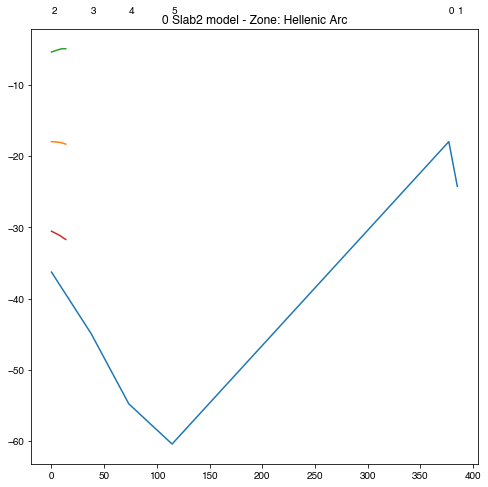

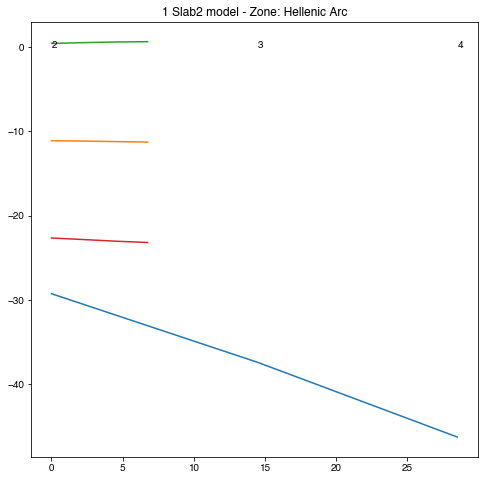

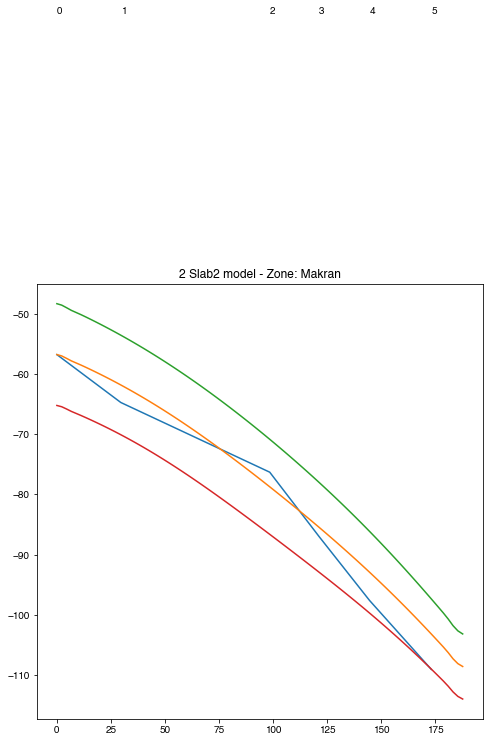

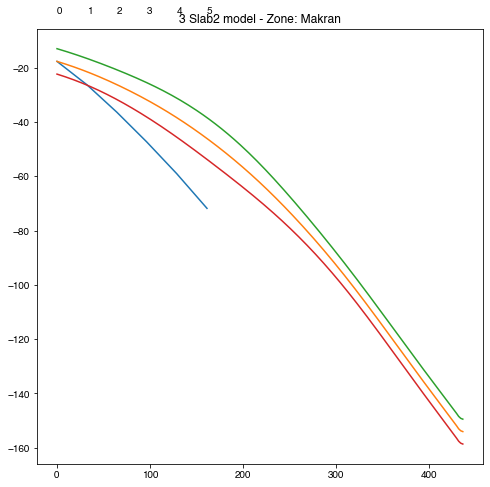

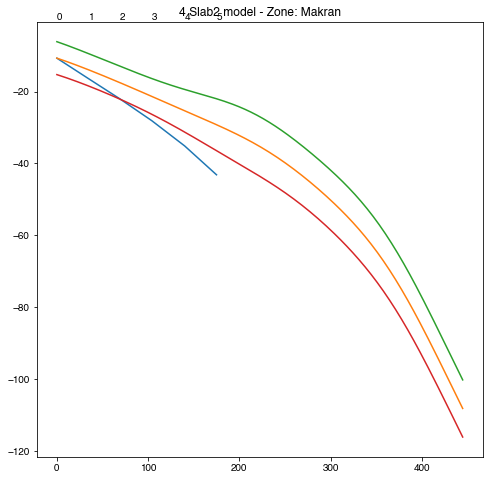

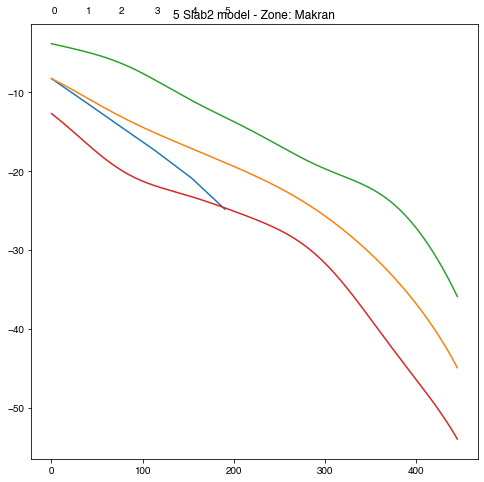

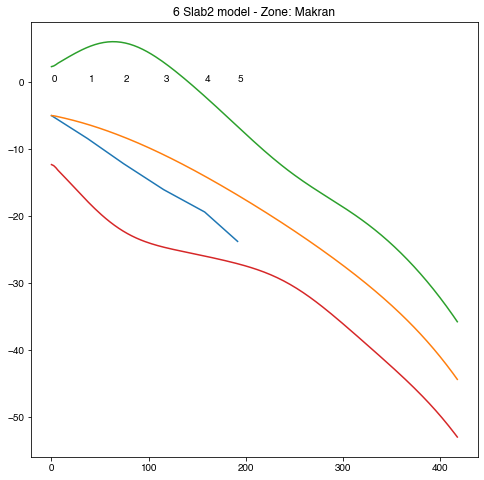

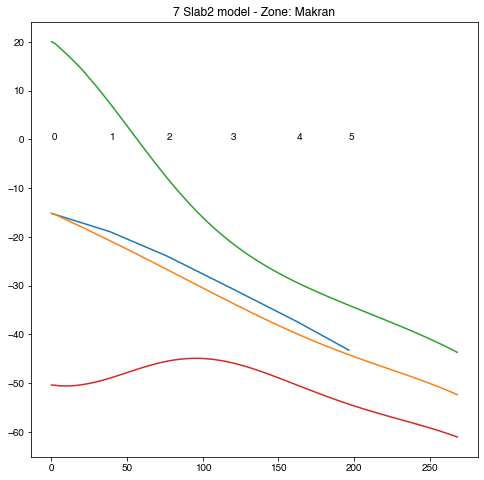

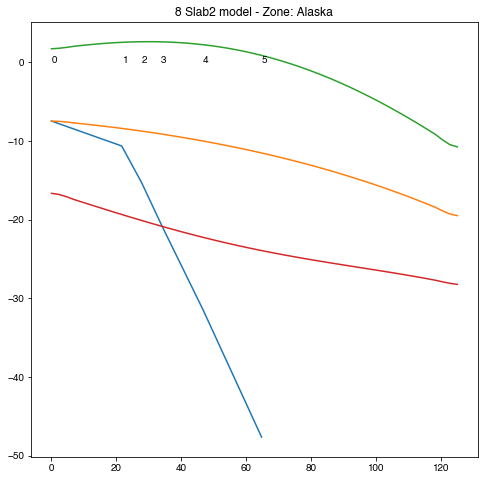

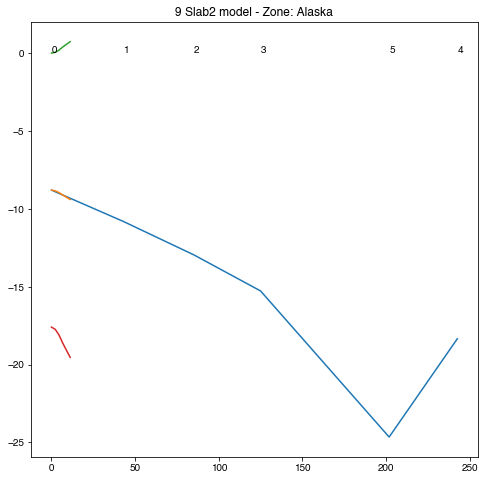

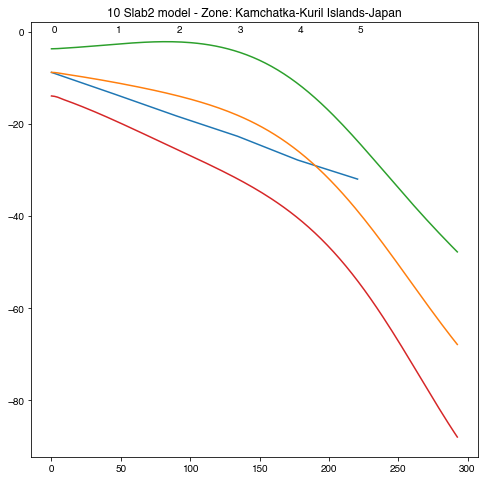

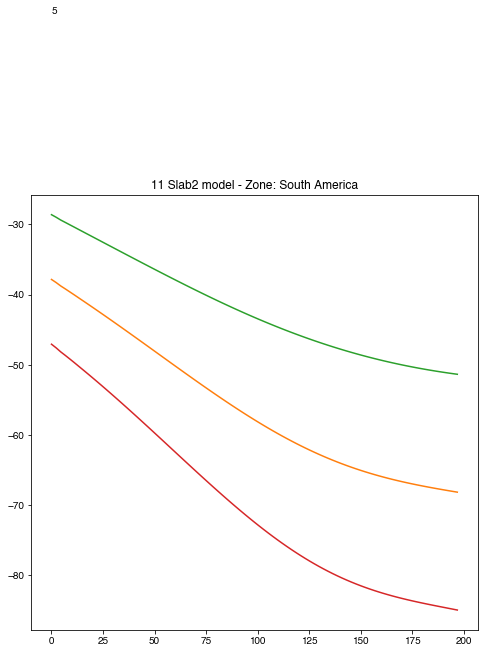

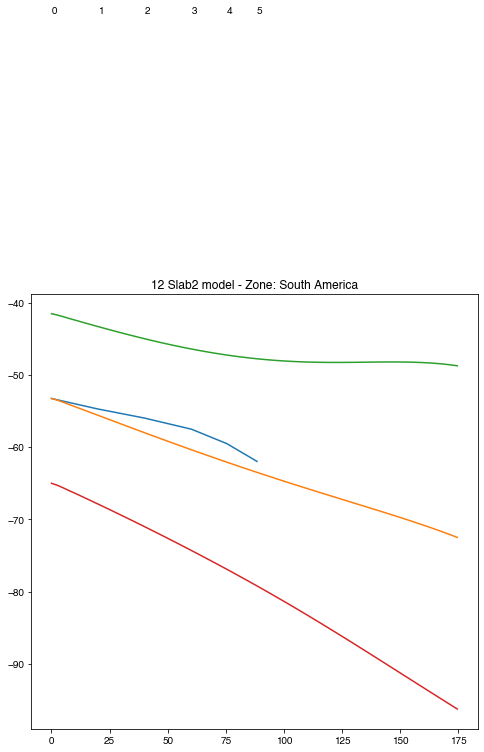

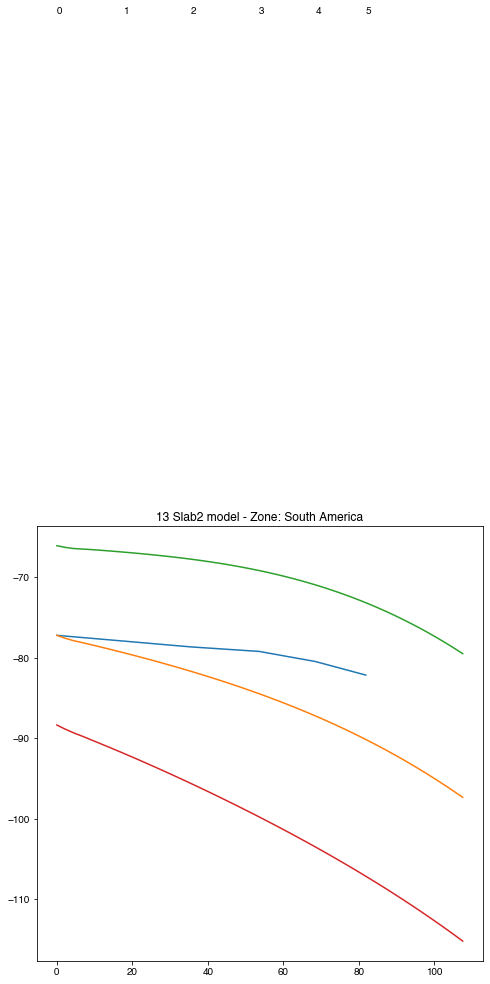

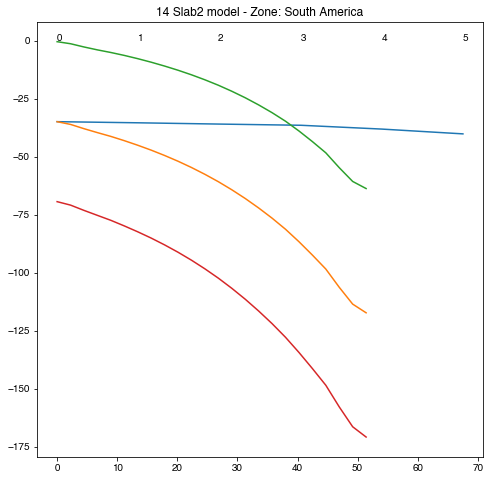

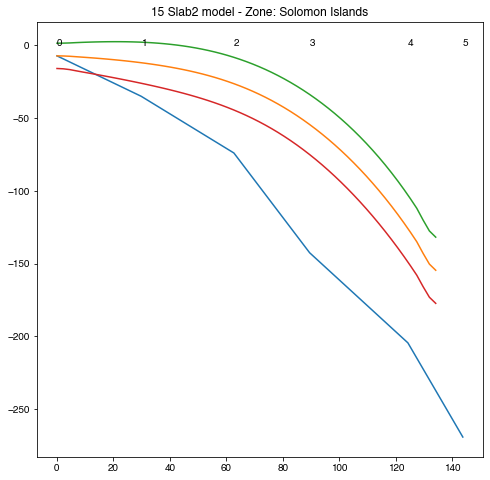

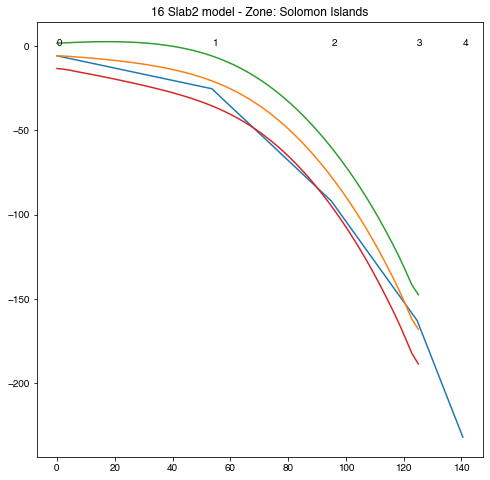

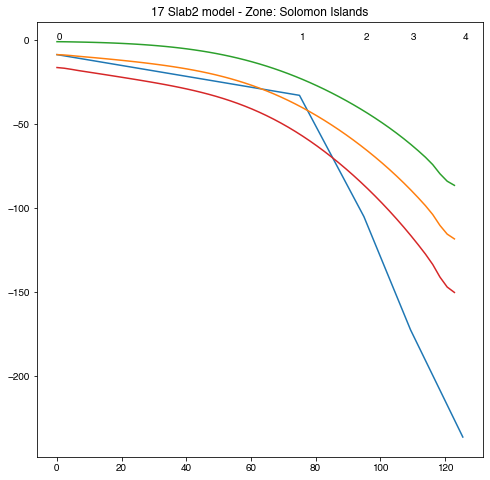

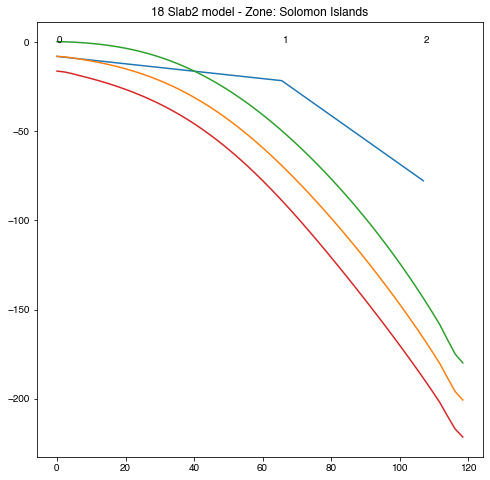

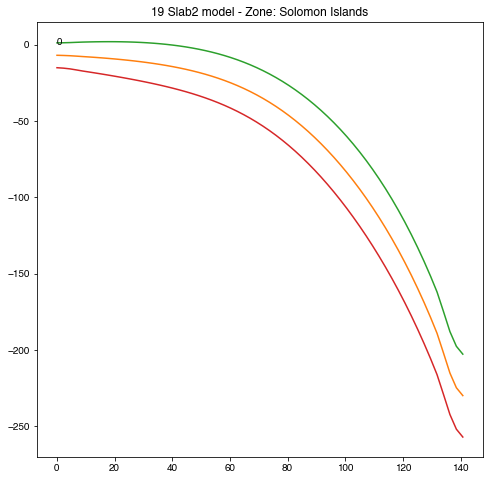

In [22]:
#enumerate
for tracks_ind,i in enumerate(tracks[:20]):
    #print(tracks_ind)
    temp_distances_tracks = []
    for ind, (row_ind, row) in enumerate(tracks[tracks_ind].iterrows()):
        #print(ind)
        if ind == 0:
            #print(ind)
            temp_distances_tracks.append(0)            
        else:
            #print('h',ind)
            #print(tracks[-100]['lon'].values[ind-1])
            lon1 = tracks[tracks_ind]['lon'].values[ind-1]
            lat1 = tracks[tracks_ind]['lat'].values[ind-1]
            lon2 = row['lon']
            lat2 = row['lat']

            lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
            dlon = lon2 - lon1
            dlat = lat2 - lat1 

            a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2

            c = 2 * np.arcsin(np.sqrt(a)) 
            r = 6371 # Radius of earth in kilometers. Use 3956 for miles

            distance = c*r
            temp_distances_tracks.append(distance + temp_distances_tracks[ind-1])
    #temp_distances.reverse()
    temp_lats = []
    temp_lons = []
    temp_distances = []
    SUBCHRONS = []
    for ind, i in enumerate(intersecting_points[tracks_ind]):
         #technically ind-1 for ind=0 is the same as the last index (i.e. tracks_ind[-1])
         #however, as this only occurs at index=0, we cover our base in lines 53-55
        lon1 = intersecting_points[tracks_ind][ind-1][1].to_lat_lon_array()[0][1]
        lat1 = intersecting_points[tracks_ind][ind-1][1].to_lat_lon_array()[0][0]
        lon2 = intersecting_points[tracks_ind][ind][1].to_lat_lon_array()[0][1]
        lat2 = intersecting_points[tracks_ind][ind][1].to_lat_lon_array()[0][0]
        SUBCHRON = int(intersecting_points[tracks_ind][ind][0])
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1 

        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2

        c = 2 * np.arcsin(np.sqrt(a)) 
        r = 6371 # Radius of earth in kilometers. Use 3956 for miles
        distance = c*r
        SUBCHRONS.append(SUBCHRON)
        temp_lats.append(lat1)
        temp_lons.append(lon1) 
        if ind == 0:
            temp_distances.append(0)
        else:
            temp_distances.append(distance + temp_distances[ind-1])

    #temp_distances.reverse()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax.plot(temp_distances, [i*-1-tracks[tracks_ind]['depth'].values[0] for i in intersecting_depths[tracks_ind]])
    ax.plot(temp_distances_tracks,tracks[tracks_ind]['depth']*-1)
    ax.plot(temp_distances_tracks,tracks[tracks_ind]['depth']*-1+tracks[tracks_ind]['depth_uncertainty'])
    ax.plot(temp_distances_tracks,tracks[tracks_ind]['depth']*-1-tracks[tracks_ind]['depth_uncertainty'])
    for i in range(len(SUBCHRONS)):
        ax.text(temp_distances[i],0, SUBCHRONS[i])
    ax.set_title(str(tracks_ind) + ' ' + str(sub_zone_names[tracks_ind]))